In [1]:
import matplotlib.pyplot as plt
from dmp_.utils.smnist_loader import MatLoader, Separate
import numpy as np
import cv2
import torch

In [2]:
data_path = './dmp_/data/s-mnist/40x40-smnist.mat'
images, outputs, scale, or_tr = MatLoader.load_data(data_path, load_original_trajectories=True)
images = np.array([cv2.resize(img, (28, 28)) for img in images]) / 255.0
data_sep = Separate()
digit_indices = data_sep.no_separation()
input_size = images.shape[1] * images.shape[2]
Zero_ind = digit_indices[2].astype(int)

In [3]:
Zero_ind.shape

(2000,)

In [4]:
inds = np.arange(1205)
np.random.shuffle(inds)
test_inds = inds[1200:]
train_inds = inds[:1200]

In [5]:
X = torch.Tensor(images[Zero_ind]).float()
Y = torch.Tensor(np.array(or_tr)[:, :, :2]).float()[Zero_ind]

X_train = X[train_inds]
Y_train = Y[train_inds]

In [6]:
inds = np.arange(X_train.shape[0])
np.random.shuffle(inds)
ind = inds[0]

In [7]:
Y_train[ind].shape

torch.Size([301, 2])

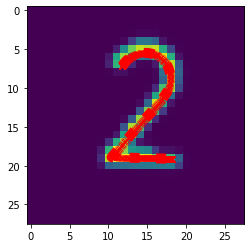

In [8]:
fig, ax = plt.subplots()
im = ax.imshow(X_train[ind])
ax.plot(Y_train[ind][:, 0] * 0.668, Y_train[ind][:, 1] * 0.668, 'x', ls='dotted', linewidth=10, color='red')
plt.show()

In [24]:
class SMNIST(object):
    def __init__(self,
                 max_ep_length=300,
                 goal_conditioned=False, digit_idx=2,
                 randomize=False, single_digit=False,
                 data_path='./dmp_/data/s-mnist/40x40-smnist.mat'):
        self.single_digit = single_digit
        self.randomize = randomize
        self.max_ep_length = max_ep_length
        self.goal_conditioned = goal_conditioned
        self.initialise_environment(data_path, digit_idx)

    @property
    def action_space(self):
        return self._action_spec

    @property
    def observation_space(self):
        return self._observation_spec

    @property
    def goal(self):
        return self._target_trajectory[self.step_no + 1]

    def load_images(self, data_path, digit_idx):
        images, outputs, scale, trajectories = MatLoader.load_data(
            data_path, load_original_trajectories=True)
        images = np.array([cv2.resize(img, (28, 28))
                          for img in images]) / 255.0
        data_sep = Separate()
        digit_indices = data_sep.no_separation()
        input_size = images.shape[1] * images.shape[2]
        return images, trajectories, digit_indices[digit_idx].astype(int)

    def initialise_environment(self, path, digit_idx):
        self._images, self._trajectories, self._desired_idx = self.load_images(
            data_path, digit_idx)
        self._action_spec = np.zeros(2)
        self._state = np.zeros(np.array(self._trajectories)[
                               :, :, :2].shape[-1])
        if not self.goal_conditioned:
            self._observation_spec = np.zeros_like(self._state)
        else:
            total_dim = env.task_goal.reshape(
                [-1]).shape[0] + env.start_state.reshape([-1]).shape[0]
            self._observation_spec = np.zeros((total_dim,))

    def reset(self, perturb_goal=False):
        if self.randomize:
            np.random.shuffle(self._desired_idx)

        self._task_goal = self._images[self._desired_idx[0]].astype(np.float32)
        self._target_trajectory = self.extract_demo()
        self._state = self._target_trajectory[0, :]
        self._episode_ended = False
        self.step_no = 0
        return self._state

    def extract_demo(self):
        return np.array(self._trajectories)[:, :, :2].astype(np.float32)[self._desired_idx[0]]

    def step(self, action):
        self.step_no += 1

        # Make sure episodes don't go on forever.
        if self.step_no == self.max_ep_length:
            self._episode_ended = True

        self._state = self._state + action
        self._goal = self._target_trajectory[self.step_no]
        distance = np.abs(self._goal-self._state)
        reward = np.exp(-np.mean(distance))

        return np.copy(self._state), reward, np.copy(self._episode_ended), None


In [32]:
def smooth(scalars, weight): 
    last = scalars[0] 
    smoothed = list() 
    for point in scalars: 
        smoothed_val = last * weight + (1-weight)*point 
        smoothed.append(smoothed_val) 
        last = smoothed_val 
    return smoothed 

In [44]:
from torch import FloatTensor, LongTensor
from torch import nn
from torch import optim


class policy_estimator(object):
    def __init__(self, env):
        self.n_inputs = env.observation_space.shape[0] # + 2
        self.n_outputs = env.action_space.shape[0]

        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, 128),
            nn.Sigmoid(),
            nn.Linear(128, 2*self.n_outputs) #,
            # nn.Tanh()
#             nn.Sigmoid()
        )

#     def predict(self, state, goal):
#         x = torch.cat((FloatTensor(state).view(1, len(state)), FloatTensor(goal).view(1, len(goal))), dim=1)
    def predict(self, state):
        x = FloatTensor(state).view(1, len(state))
        action_probs = self.network(x)
        return action_probs.squeeze()[:2], torch.exp(action_probs.squeeze()[2:])

def discount_rewards(rewards, gamma=0.99):
    r = np.array([gamma**i * rewards[i] for i in range(len(rewards))])
    # Reverse the array direction for cumsumand then
    # revert back to the original
    r = r[::-1].cumsum()[::-1]
    # subtracting mean helps stabilize rewards 
    # if they're all positive, gradients change more with negative or
    # below average rewards than they would if they weren't normalized.
    return r - r.mean()

def reinforce(env, policy_estimator, num_episodes=5000,
                batch_size=64, gamma=0.99):
    # Set up lists to hold results in
    total_rewards = []
    total_loss = []
    batch_rewards = []
    batch_actions = []
    batch_log_probs = []
    batch_states = []
    batch_counter = 1
    batch_goals = []

    # Define optimizer
    optimizer = optim.Adam(policy_estimator.network.parameters(), lr=0.001)

    action_space = np.arange(env.action_space.shape[0])
    ep = 0
    while ep < num_episodes:
        s_0 = env.reset()
        g_0 = env.goal
        states = []
        rewards = []
        goals = []
        actions = []
        distributions = []
        done = False
        while done == False:
            # Get actions and convert to numpy array
#             means, sigs = policy_estimator.predict(s_0)
#             means, sigs = policy_estimator.predict(s_0, g_0)
            feature = g_0 - s_0
            means, sigs = policy_estimator.predict(feature)
            # action = np.random.choice(action_space, p=action_probs)
            dists = torch.distributions.Normal(means, sigs)
            action = dists.sample().detach().numpy()
            s_1, r, done, _ = env.step(action)
            states.append(s_0)
            rewards.append(r)
            goals.append(g_0)
            actions.append(action)
            s_0 = s_1

            # If done, batch data
            if done:
                batch_rewards.extend(discount_rewards(rewards, gamma))
                batch_states.extend(states)
                batch_actions.extend(actions)
                batch_goals.extend(goals)
                batch_counter += 1
                total_rewards.append(sum(rewards))

                # If batch is complete, update network
                if batch_counter == batch_size:
                    optimizer.zero_grad()
                    state_tensor = FloatTensor(batch_states)
                    reward_tensor = FloatTensor(batch_rewards)
                    action_tensor = torch.as_tensor(batch_actions)
                    goal_tensor = FloatTensor(batch_goals)
                    # Calculate loss
#                     inpt_tensor = state_tensor
#                     inpt_tensor = torch.cat((state_tensor, goal_tensor), dim=1)
                    inpt_tensor = goal_tensor-state_tensor
                    _vars = policy_estimator.network(inpt_tensor)
                    dists = torch.distributions.Normal(_vars[:, :2], torch.exp(_vars[:, 2:]))
                    # samples = dists.sample()
                    log_prob = dists.log_prob(action_tensor)
                    selected_logprobs = reward_tensor * log_prob.sum(dim=-1)
                    loss = -selected_logprobs.mean()
                    total_loss.append(loss.detach().numpy())

                    # Calculate gradients
                    loss.backward()
                    # Apply gradients
                    optimizer.step()

                    batch_rewards = []
                    batch_actions = []
                    batch_states = []
                    batch_counter = 1
                    batch_goals = []

                    avg_rewards = np.mean(total_rewards[-100:])
                    avg_loss = np.mean(total_loss[-100:])
                    # Print running average
                    print('\rEp: {0} Average rew of last 10: {1} and loss: {2}'.format(ep+1, avg_rewards, avg_loss), end="")
                ep += 1

    return np.array(states[:]), total_rewards

In [46]:
# no goal
env = SMNIST()
policy_est = policy_estimator(env)
trajectory, rewards = reinforce(env, policy_est)
plt.plot(np.arange(len(rewards)), smooth(rewards, 0.6))
plt.savefig("plot.jpg")
print("Done")

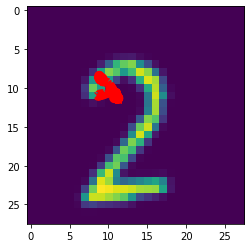

In [23]:
fig, ax = plt.subplots()
im = ax.imshow(env._task_goal)
ax.plot(trajectory[:, 0] * 0.668, trajectory[:, 1] * 0.668, 'x', ls='dotted', linewidth=10, color='red')
plt.show()

Ep: 4977 Average rew of last 10: 9.589622358485784 and loss: -0.129245430231094367Done


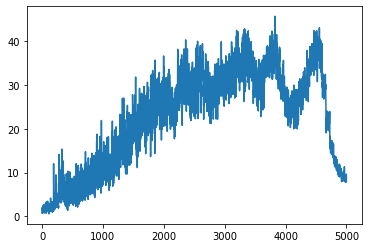

In [37]:
# immediate next as goal
env = SMNIST()
policy_est = policy_estimator(env)
trajectory, rewards = reinforce(env, policy_est)
plt.plot(np.arange(len(rewards)), smooth(rewards, 0.6))
plt.savefig("plot.jpg")
print("Done")

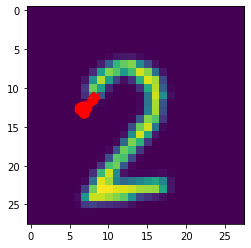

In [38]:
fig, ax = plt.subplots()
im = ax.imshow(env._task_goal)
ax.plot(trajectory[:, 0] * 0.668, trajectory[:, 1] * 0.668, 'x', ls='dotted', linewidth=10, color='red')
plt.show()

Ep: 4977 Average rew of last 10: 35.79967510426778 and loss: -0.0357664152979850854Done


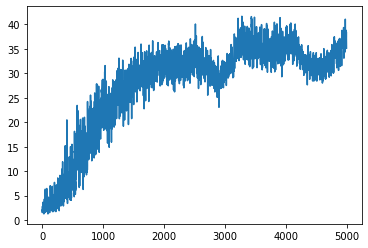

In [47]:
# Squared distance as a feature
env = SMNIST()
policy_est = policy_estimator(env)
trajectory, rewards = reinforce(env, policy_est)
plt.plot(np.arange(len(rewards)), smooth(rewards, 0.6))
plt.savefig("plot.jpg")
print("Done")

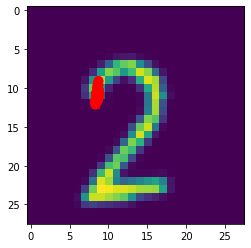

In [48]:
fig, ax = plt.subplots()
im = ax.imshow(env._task_goal)
ax.plot(trajectory[:, 0] * 0.668, trajectory[:, 1] * 0.668, 'x', ls='dotted', linewidth=10, color='red')
plt.show()